This notebook is part of the *orix* documentation https://orix.rtfd.io. Links to the documentation won’t work from the notebook.

# Crystal geometry

This notebook details how to perform operations with and plot directions with
respect to the crystal reference system using Miller indices with the
[orix.vector.Miller](reference.rst#orix.vector.Miller) class.

Many of the initial examples, explaining basic crystallographic computations with
crystal lattice directions $[uvw]$ and crystal lattice planes $(hkl)$, are taken
from the textbook
*Introduction to Conventional Transmission Electron Microscopy*
(<cite data-cite="degraef2003introduction">De Graef (2003)</cite>).
Some of the later examples are also inspired by MTEX' excellent documentation on
[Miller indices](https://mtex-toolbox.github.io/CrystalDirections.html) and
[operations with them](https://mtex-toolbox.github.io/CrystalOperations.html).

In [1]:
%matplotlib inline

from diffpy.structure import Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np
from orix.crystal_map import Phase
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import AxAngle, Miller, Vector3d


plt.rcParams.update({
    "figure.figsize": (7, 7),
    "font.size": 20,
    "axes.grid": True,
    "lines.markersize": 10,
    "lines.linewidth": 2,
})

To start with, let's create a tetragonal crystal with lattice parameters
$a$ = $b$ = 0.5 nm and $c$ = 1 nm and symmetry elements described by point group
*4*

In [2]:
tetragonal = Phase(
    point_group="4",
    structure=Structure(lattice=Lattice(0.5, 0.5, 1, 90, 90, 90))
)
print(tetragonal)
print(tetragonal.structure.lattice)

<name: . space group: None. point group: 4. proper point group: 4. color: tab:blue>
Lattice(a=0.5, b=0.5, c=1, alpha=90, beta=90, gamma=90)


Here, the [Phase](reference.rst#orix.crystal_map.Phase) class attaches a point group symmetry,
[Symmetry](reference.rst#orix.quaternion.Symmetry), to a
[Structure](https://www.diffpy.org/diffpy.structure/package.html#diffpy.structure.structure.Structure)
containing a
[Lattice](https://www.diffpy.org/diffpy.structure/mod_lattice.html#diffpy.structure.lattice.Lattice)
(where the crystal axes are defined), and possibly some
[Atom](https://www.diffpy.org/diffpy.structure/mod_atom.html#diffpy.structure.atom.Atom)s.

## Directions $[uvw]$

A crystal lattice direction $\mathbf{m} = u \cdot \mathbf{a} + v \cdot \mathbf{b} + w \cdot \mathbf{c}$
is a vector with coordinates $u, v, w$ with respect to the crystal axes $\mathbf{a}, \mathbf{b}, \mathbf{c}$,
and is denoted $[uvw]$. We can create a set of these Miller indices by passing a list/array/tuple to `uvw` in
[Miller](reference.rst#orix.vector.Miller)

Miller (2,), point group 4, uvw
[[1. 2. 0.]
 [3. 1. 1.]]

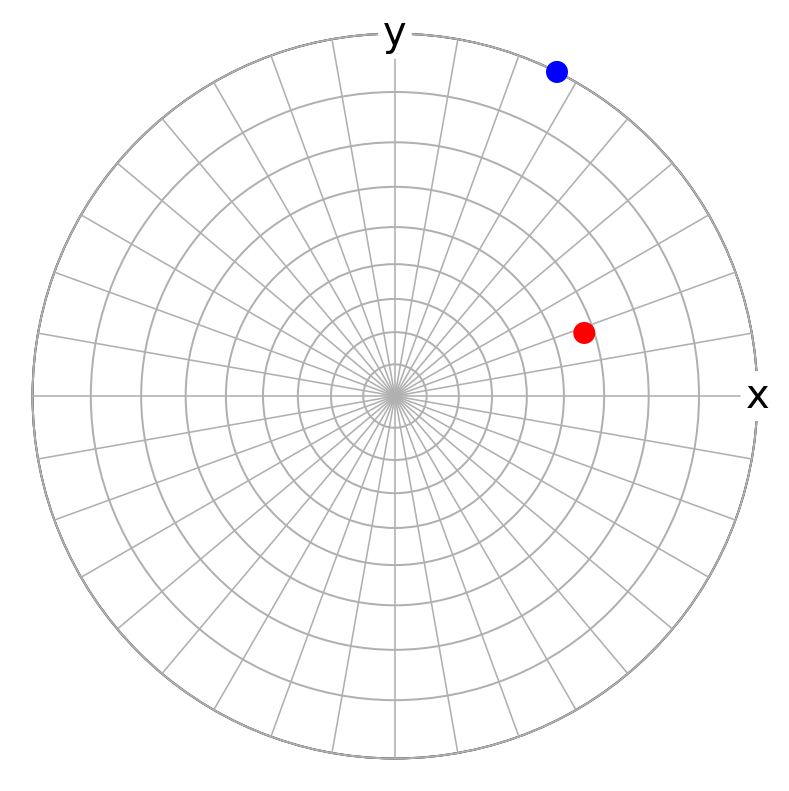

In [3]:
m1 = Miller(uvw=[[1, 2, 0], [3, 1, 1]], phase=tetragonal)
m1.scatter(axes_labels=["x", "y", None], c=["b", "r"])
m1

Here, we plotted the lattice directions in the stereographic projection using the
[Vector3d.scatter()](reference.rst#orix.vector.Vector3d.scatter) plotting
method, which also works for `Miller.scatter()` since the `Miller` class
inherits most of the functionality in the `Vector3d` class.

Let's compute the dot product in nanometres and the angle in degrees between the vectors

In [6]:
m1[0].dot(m1[1])

array([1.25])

In [7]:
np.rad2deg(m1[0].angle_with(m1[1]))

array([53.3007748])

The length of a direct lattice vector is available via the
[Miller.length](reference.rst#orix.vector.Miller.length) property, given in
lattice parameter units (nm in this case)

In [8]:
Miller(uvw=[0, -0.5, 0.5], phase=tetragonal).length

array([0.55901699])

## Planes $(hkl)$

A crystal lattice plane $(hkl)$ is described by its normal vector
$\mathbf{n} = h\cdot\mathbf{a^*} + k\cdot\mathbf{b^*} + l\cdot\mathbf{c^*}$,
where $\mathbf{a^*}, \mathbf{b^*}, \mathbf{c^*}$ are the reciprocal crystal
axes. As for crystal directions $[uvw]$, we can create a set of these Miller
indices by passing `hkl` instead of `uvw` to
[Miller](reference.rst#orix.vector.Miller)

Miller (2,), point group 4, hkl
[[1. 2. 0.]
 [3. 1. 1.]]

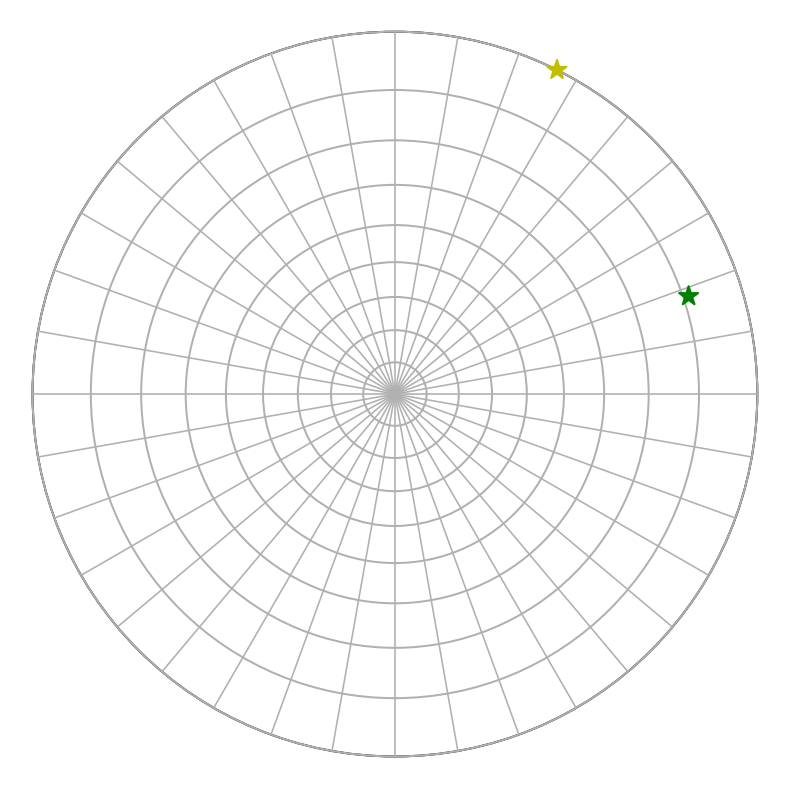

In [9]:
m2 = Miller(hkl=m1.uvw, phase=tetragonal)
m2.scatter(c=["y", "g"], marker="*")
m2

Let's compute the angle in degrees between the lattice plane normals

In [16]:
np.rad2deg(m2[0].angle_with(m2[1]))

array([45.69879831])

Note that the lattice plane normals $(hkl)$ are not always parallel to the
lattice directions $[uvw]$, even if the indices are the same

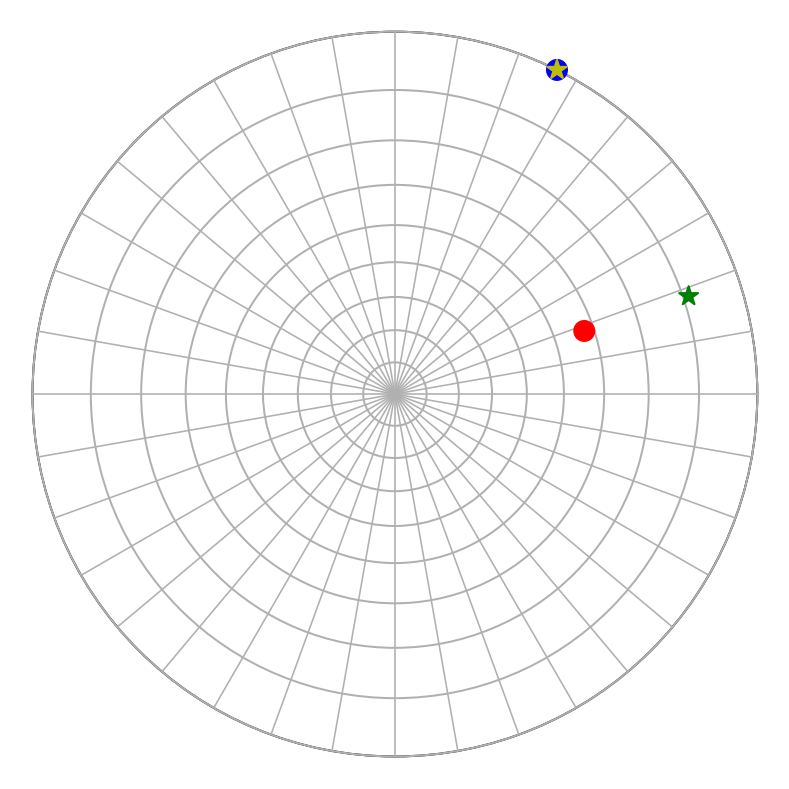

In [17]:
fig = m1.scatter(return_figure=True, c=["b", "r"])
m2.scatter(figure=fig, c=["y", "g"], marker="*")

We can get the reciprocal components of the lattice vector [114] (i.e. which
lattice plane the [114] direction is perpendicular to) by accessing
[Miller.hkl](reference.rst#orix.vector.Miller.hkl) for a `Miller` object with
crystal directions (or [Miller.uvw](reference.rst#orix.vector.Miller.uvw) for a
`Miller` object with crystal plane normals)

In [18]:
Miller(uvw=[1, 1, 4], phase=tetragonal).hkl

array([[0.25, 0.25, 4.  ]])

We see that the lattice vector [114] is perpendicular to the lattice plane (1 1 16).

The length of reciprocal lattice vectors can also be accessed via the
`Miller.length` property, and equals
$\left|\mathbf{g}_{\mathrm{hkl}}\right| = \frac{1}{d_{\mathrm{hkl}}}$ in
reciprocal lattice parameter units (nm^-1 in this case), meaning we can obtain the
interplanar spacing $d_{\mathrm{hkl}}$

In [19]:
m2.length

array([4.47213595, 6.40312424])

In [20]:
1 / m2.length

array([0.2236068 , 0.15617376])

## Zone axes

The cross product of the lattice vectors [110] and [111] in the tetragonal
crystal, in direct space, is described by a vector expressed in reciprocal
space, $(hkl)$

In [21]:
m3 = Miller(uvw=[[1, 1, 0], [1, 1, 1]], phase=tetragonal)
m3perp = m3[0].cross(m3[1])
m3perp

Miller (1,), point group 4, hkl
[[ 0.25 -0.25  0.  ]]

The exact "indices" are returned, however, we can get a new `Miller` instance
with the indices rounded down or up to the *closest* smallest integer via the
[Miller.round()](reference.rst#orix.vector.Miller.round) method

In [22]:
m3perp.round()

Miller (1,), point group 4, hkl
[[ 1. -1.  0.]]

The maximum index that `Miller.round()` might return can be set by passing the
`max_index` parameter.

We can plot these direct lattice vectors $[uvw]$ and the vectors normal to the
cross product vector, i.e. normal to the reciprocal lattice vector $(hkl)$

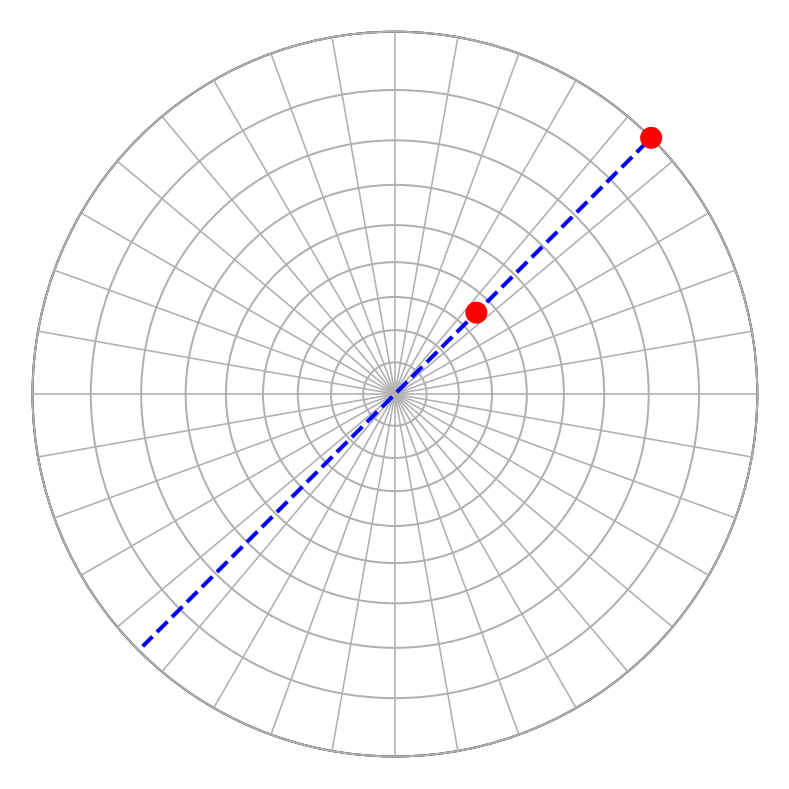

In [23]:
fig = m3.scatter(return_figure=True, c="r")
m3perp.draw_circle(figure=fig, color="b", linestyle="--")

Likewise, the cross product of reciprocal lattice vectors (110) and (111)
results in a direct lattice vector

In [24]:
m4 = Miller(hkl=[[1, 1, 0], [1, 1, 1]], phase=tetragonal)
m4perp = m4[0].cross(m4[1]).round()
m4perp

Miller (1,), point group 4, uvw
[[ 1. -1.  0.]]

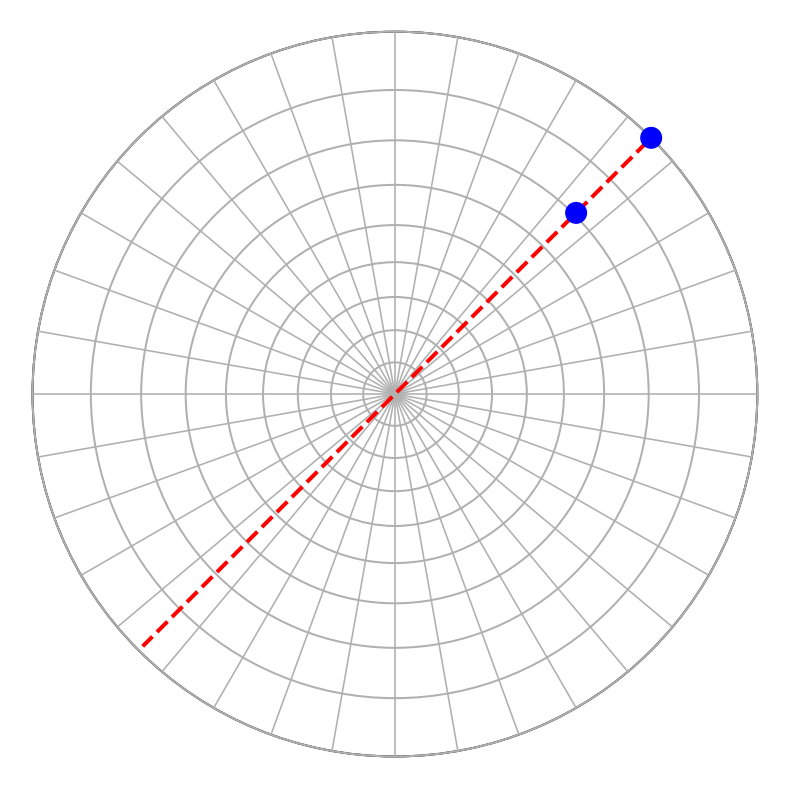

In [25]:
fig = m4.scatter(return_figure=True, c="b")
m4perp.draw_circle(figure=fig, color="r", linestyle="--")

## Trigonal and hexagonal index conventions

Crystal lattice vectors and planes in lattices with trigonal and hexagonal
crystal symmetry are typically expressed in Weber symbols $[UVTW]$ and
Miller-Bravais indices $(hkil)$. The definition of $[UVTW]$ used in orix follows
*Introduction to Conventional Transmission Electron Microscopy* (DeGraef, 2003)

\begin{align}
U &= \frac{2u - v}{3},\\
V &= \frac{2v - u}{3},\\
T &= -\frac{u + v}{3},\\
W &= w.
\end{align}

For a plane, the $h$, $k$ and $l$ indices are the same in $(hkl)$ and $(hkil)$,
and $i = -(h + k)$.

The first three Miller indices always sum up to zero, i.e.

\begin{align}
U + V + T &= 0,\\
h + k + i &= 0.
\end{align}

In [26]:
trigonal = Phase(
    point_group="321",
    structure=Structure(lattice=Lattice(4.9, 4.9, 5.4, 90, 90, 120))
)
trigonal

<name: . space group: None. point group: 321. proper point group: 32. color: tab:blue>

In [27]:
m5 = Miller(UVTW=[2, 1, -3, 1], phase=trigonal)
m5

Miller (1,), point group 321, UVTW
[[ 2.  1. -3.  1.]]

In [28]:
m6 = Miller(hkil=[1, 1, -2, 3], phase=trigonal)
m6

Miller (1,), point group 321, hkil
[[ 1.  1. -2.  3.]]

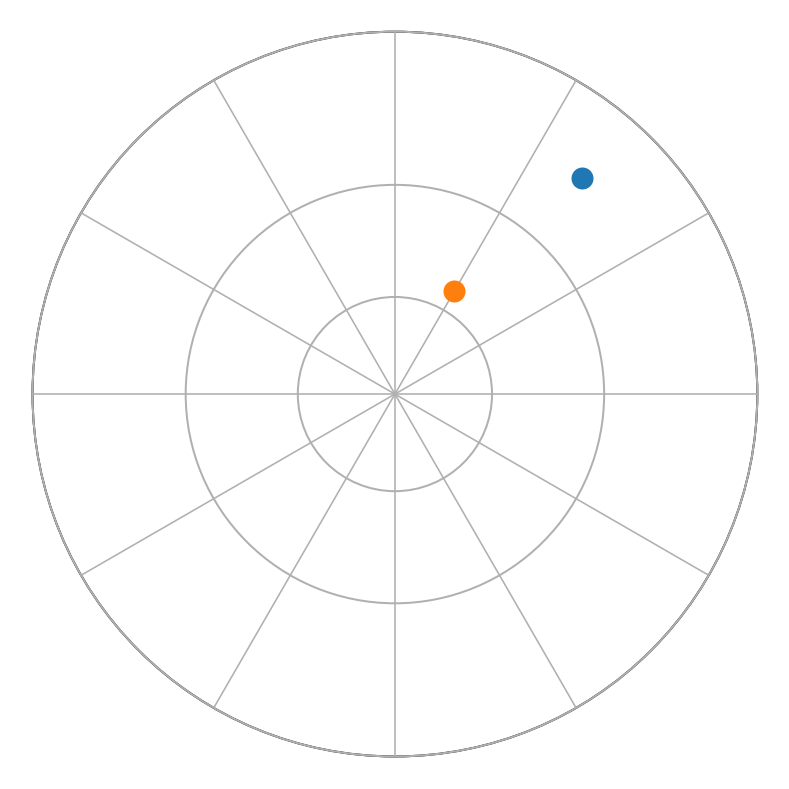

In [29]:
fig = m5.scatter(return_figure=True, c="C0", grid_resolution=(30, 30))
m6.scatter(figure=fig, c="C1")

One can change the coordinate format of the Miller class, however this does not
change the vector, since all vectors are stored with respect to the cartesian
coordinate system internally

In [32]:
print(m6, "\n\n", m6.data)

Miller (1,), point group 321, hkil
[[ 1.  1. -2.  3.]] 

 [[0.20408163 0.35347976 0.55555556]]


In [33]:
m6.coordinate_format = "UVTW"
print(m6, "\n\n", m6.data)

Miller (1,), point group 321, UVTW
[[ 0.0278  0.0278 -0.0555  0.1029]] 

 [[0.20408163 0.35347976 0.55555556]]


Getting the closest integer indices, however, changes the vector

In [34]:
m6round = m6.round()
print(m6round, "\n\n", m6round.data)

Miller (1,), point group 321, UVTW
[[ 3.  3. -6. 11.]] 

 [[22.05       38.19172031 59.4       ]]


## Symmetrically equivalent directions and planes

The point group symmetry elements of the crystal lattice can be applied to
to describe symmetrically equivalent crystal directions and planes. This applies
to crystals in all seven systems, but we'll use the cubic crystal as an example
because of its high symmetry

In [35]:
cubic = Phase(point_group="m-3m", structure=Structure())
print(cubic, "\n", cubic.structure.lattice.abcABG())

<name: . space group: None. point group: m-3m. proper point group: 432. color: tab:blue> 
 (1.0, 1.0, 1.0, 90.0, 90.0, 90.0)


The directions parallel to the crystal axes ($\mathbf{a}$, $\mathbf{b}$,
$\mathbf{c}$) given by $[100]$, $[\bar{1}00]$, $[010]$, $[0\bar{1}0]$,
$[001]$, and $[00\bar{1}]$ ($\bar{1}$ means "-1") are symmetrically equivalent,
and can be obtained using
[Miller.symmetrise()](reference.rst#orix.vector.Miller.symmetrise)

In [36]:
m7 = Miller(uvw=[1, 0, 0] , phase=cubic)
m7.symmetrise(unique=True)

Miller (6,), point group m-3m, uvw
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]
 [ 0.  0. -1.]]

Without passing `unique=True`, since the cubic crystal symmetry is described by
48 symmetry operations (or elements), 48 directions would have been returned.

These six directions, known as a family, may be expressed collectively as
$\left<100\right>$, the brackets implying all six permutations or variants of
1, 0, 0. This particular family is said to have a multiplicity of 6

In [37]:
m7.multiplicity

array([6])

In [38]:
m8 = Miller(uvw=[[1, 0, 0], [1, 1, 0], [1, 1, 1]], phase=cubic)
m8

Miller (3,), point group m-3m, uvw
[[1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 1.]]

In [39]:
m8.multiplicity

array([ 6, 12,  8])

Let's plot the symmetrically equivalent directions from the direction families
$\left<100\right>$, $\left<110\right>$, and $\left<111\right>$ impinging on the
upper hemisphere. By also returning the indices of which family each
symmetrically equivalent direction belongs to from `Miller.symmetrise()`, we can
give a unique color per family

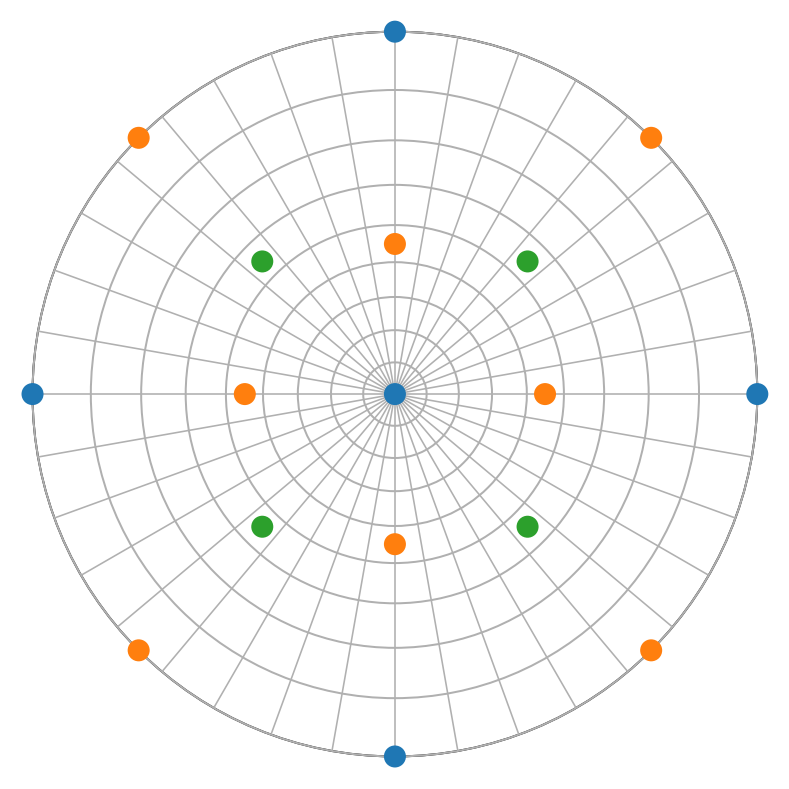

In [40]:
m9, idx = m8.symmetrise(unique=True, return_index=True)

fig = m9[idx == 0].scatter(c="C0", return_figure=True)
for i in range(1, m9.size):
    m9[idx == i].scatter(c=f"C{i}", figure=fig)

Similarly, symmetrically equivalent planes $(hkl)$ can be collectively
expressed as planes of the form $\{hkl\}$

In [41]:
m10 = Miller(hkl=[[1, 0, 0], [1, 1, 0], [1, 1, 1]], phase=cubic)
m10.multiplicity

array([ 6, 12,  8])

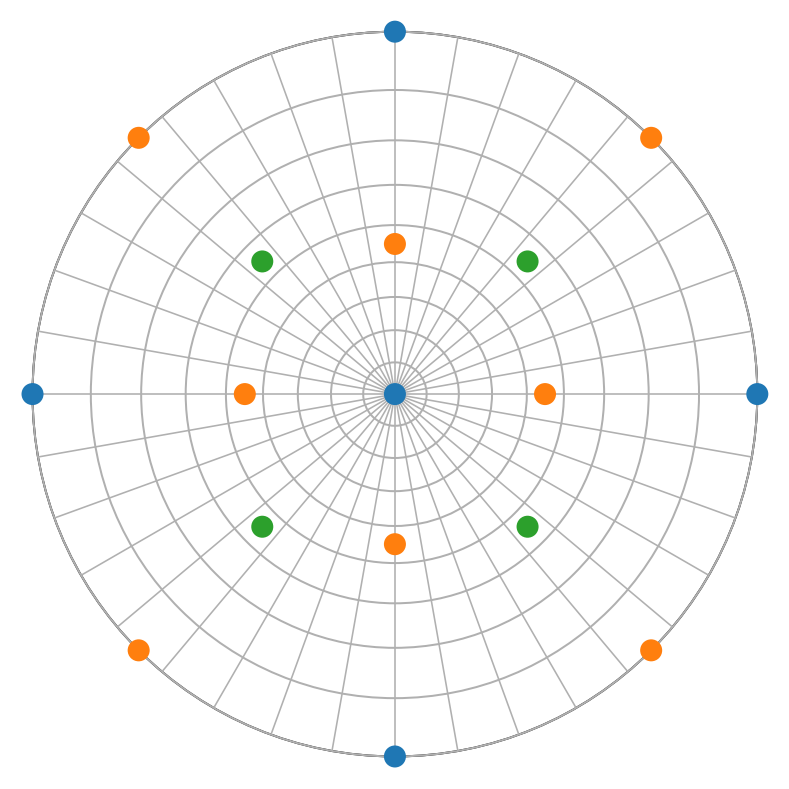

In [42]:
fig = m10[0].symmetrise(unique=True).scatter(c="C0", return_figure=True)
for i in range(1, m10.size):
    m10[i].symmetrise(unique=True).scatter(c=f"C{i}", figure=fig)

We computed the angles between directions and plane normals earlier in this
notebook. In general,
[Miller.angle_with()](reference.rst#orix.vector.Miller.angle_with) does not
consider symmetrically equivalent directions, unless `use_symmetry=True` is
passed. Consider $(100)$ and $(\bar{1}00)$ and $(111)$ and $(\bar{1}11)$ in the stereographic
plot above

In [43]:
m11 = Miller(hkl=[[1, 0, 0], [1, 1, 1]], phase=cubic)
m12 = Miller(hkl=[[-1, 0, 0], [-1, 1, 1]], phase=cubic)

In [45]:
np.rad2deg(m11.angle_with(m12))

array([180.        ,  70.52877937])

In [46]:
np.rad2deg(m11.angle_with(m12, use_symmetry=True))

array([0., 0.])

Thus, passing `use_symmetry=True` ensures that the smallest angles between
`m11` and the symmetrically equivalent directions to `m12` are found.

## Directions and planes in rotated crystals

Let's consider the orientation of a cubic crystal which under a rotation of
$45^{\circ}$ about the sample $\mathbf{Z}$ axis has its crystal reference frame
coinsiding with the sample reference frame

In [55]:
o = Orientation.from_euler(np.deg2rad([45, 0, 0]))
o.symmetry = cubic.point_group
o = o.map_into_symmetry_reduced_zone()
o

Orientation (1,) m-3m
[[ 0.9239  0.      0.     -0.3827]]

We can apply this orientation to a crystal direction $[uvw]$ to find this
direction in this particular crystal with respect to the sample coordinate
system

In [56]:
m12 = Miller(uvw=[1, 1, 1], phase=cubic)
o * m12

Miller (1,), point group m-3m, uvw
[[ 1.4142 -0.      1.    ]]

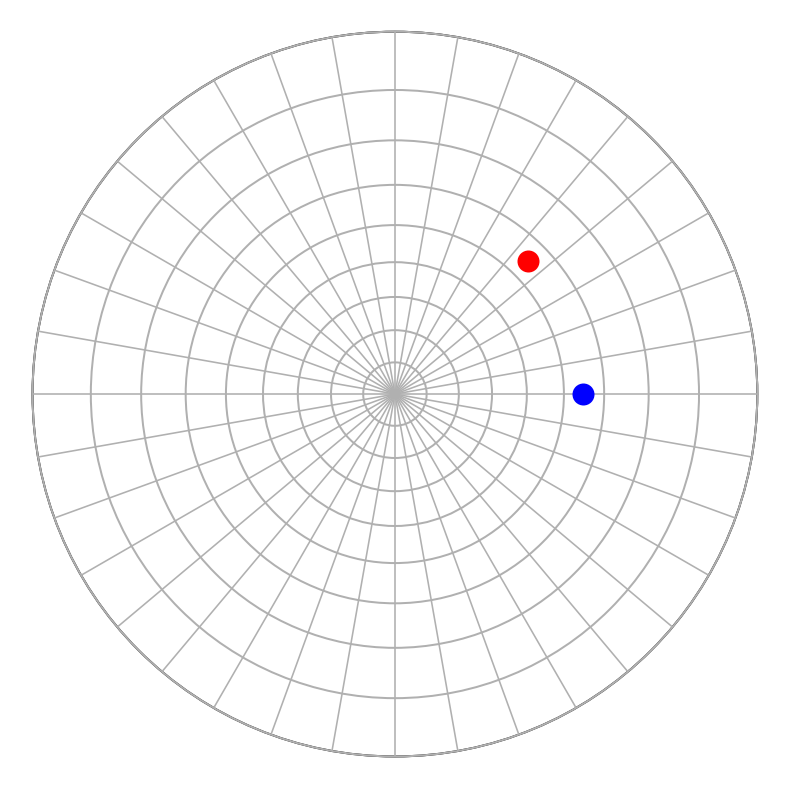

In [57]:
fig = m12.scatter(c="r", return_figure=True)
(o * m12).scatter(figure=fig, c="b")

We can apply the crystal symmetry to obtain the coordinates with respect to the
sample reference frame for all crystallographically equivalent directions

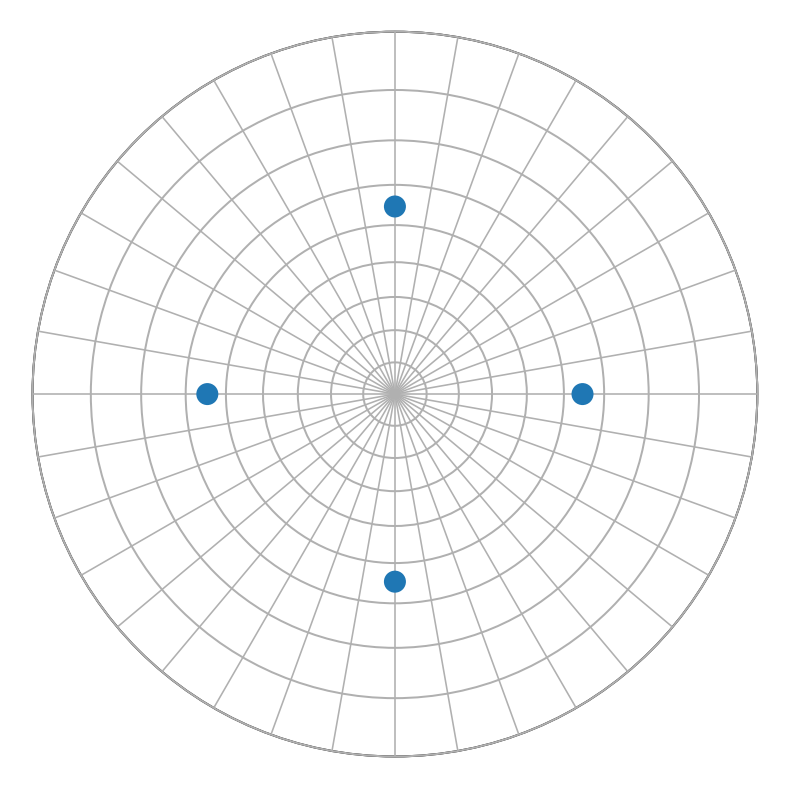

In [58]:
(o * m12.symmetrise(unique=True)).scatter()

In [60]:
o2 = Orientation.from_euler(np.deg2rad([10, 20, 30]))
o2.symmetry = trigonal.point_group
o2 = o2.map_into_symmetry_reduced_zone()
o2

Orientation (1,) 321
[[ 0.9254 -0.171   0.0302 -0.3368]]

In [61]:
m13 = Miller(hkil=[1, -1, 0, 0], phase=trigonal)
m13

Miller (1,), point group 321, hkil
[[ 1. -1. -0.  0.]]

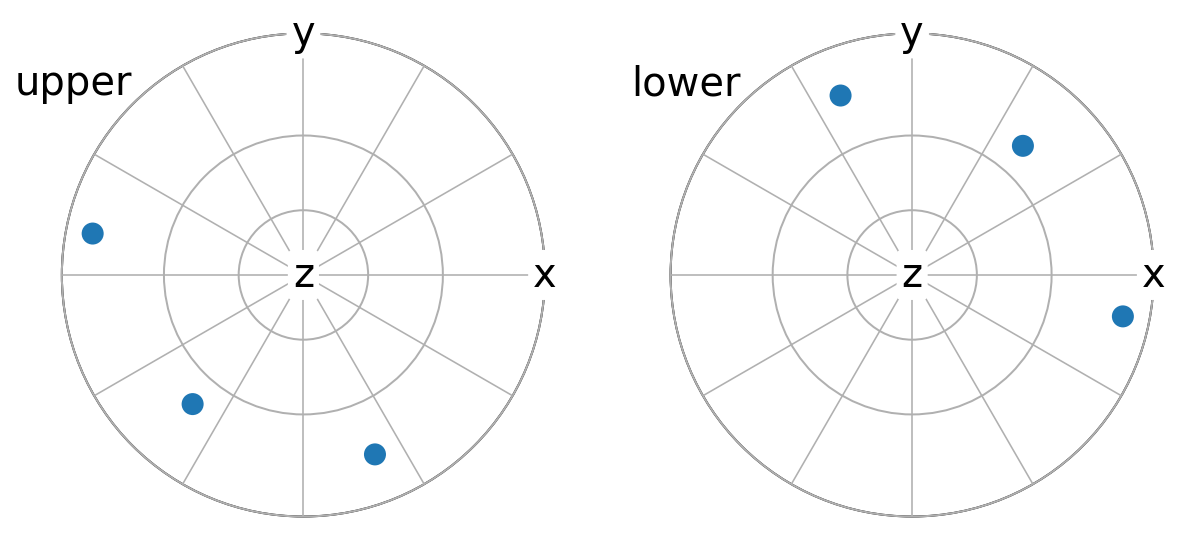

In [62]:
p = o2 * m13.symmetrise(unique=True)
p.scatter(
    hemisphere="both",
    grid_resolution=(30, 30),
    figure_kwargs=dict(figsize=(10, 5)),
    axes_labels=["x", "y", "z"],
)

The stereographic plots above are essentially the $\{1\bar{1}00\}$ pole figure
representation of the orientation $O_2$.

___

## A diamond [111] pole figure

Let's make a pole figure in the [111] direction of the diamond structure, as
seen in
[this figure from Wikipedia](https://commons.wikimedia.org/wiki/File:DiamondPoleFigure111.png).

The figure caption reads as follows

> *The spots in the stereographic projection show the orientation of lattice planes with the 111 in the center. Only poles for a non-forbidden Bragg reflection are shown between Miller indices -10 <= (h,k,l) <= 10. The green spots contain Miller indices up to 3, for example 111, 113, 133, 200 etc in its fundamental order. Red are those raising to 5, ex. 115, 135, 335 etc, while blue are all remaining until 10, such as 119, 779, 10.10.00 etc.*

In [63]:
diamond = Phase(space_group=227)
md = Miller.from_highest_indices(phase=diamond, uvw=[10, 10, 10])
md

Miller (9260,), point group m-3m, uvw
[[ 10.  10.  10.]
 [ 10.  10.   9.]
 [ 10.  10.   8.]
 ...
 [-10. -10.  -8.]
 [-10. -10.  -9.]
 [-10. -10. -10.]]

Remove duplicates under symmetry using [Miller.unique()](reference.rst#orix.vector.Miller.unique)

In [64]:
md2 = md.unique(use_symmetry=True)
md2

Miller (285,), point group m-3m, uvw
[[ 1.  0.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]
 [ 9.  0.  0.]
 [10.  0.  0.]
 [ 1.  1.  0.]
 [ 2.  1.  0.]
 [ 3.  1.  0.]
 [ 4.  1.  0.]
 [ 5.  1.  0.]
 [ 6.  1.  0.]
 [ 7.  1.  0.]
 [ 8.  1.  0.]
 [ 9.  1.  0.]
 [10.  1.  0.]
 [ 2.  2.  0.]
 [ 3.  2.  0.]
 [ 4.  2.  0.]
 [ 5.  2.  0.]
 [ 6.  2.  0.]
 [ 7.  2.  0.]
 [ 8.  2.  0.]
 [ 9.  2.  0.]
 [10.  2.  0.]
 [ 3.  3.  0.]
 [ 4.  3.  0.]
 [ 5.  3.  0.]
 [ 6.  3.  0.]
 [ 7.  3.  0.]
 [ 8.  3.  0.]
 [ 9.  3.  0.]
 [10.  3.  0.]
 [ 4.  4.  0.]
 [ 5.  4.  0.]
 [ 6.  4.  0.]
 [ 7.  4.  0.]
 [ 8.  4.  0.]
 [ 9.  4.  0.]
 [10.  4.  0.]
 [ 5.  5.  0.]
 [ 6.  5.  0.]
 [ 7.  5.  0.]
 [ 8.  5.  0.]
 [ 9.  5.  0.]
 [10.  5.  0.]
 [ 6.  6.  0.]
 [ 7.  6.  0.]
 [ 8.  6.  0.]
 [ 9.  6.  0.]
 [10.  6.  0.]
 [ 7.  7.  0.]
 [ 8.  7.  0.]
 [ 9.  7.  0.]
 [10.  7.  0.]
 [ 8.  8.  0.]
 [ 9.  8.  0.]
 [10.  8.  0.]
 [ 9.  9.  0.]
 [10.  9.  0.]
 [1

Symmetrise to get all symmetrically equivalent directions

In [65]:
md3 = md2.symmetrise(unique=True)
md3

Miller (9260,), point group m-3m, uvw
[[  1.   0.   0.]
 [  0.   1.   0.]
 [ -1.   0.   0.]
 ...
 [ 10.  10. -10.]
 [-10.  10. -10.]
 [-10. -10. -10.]]

Remove forbidden reflections in face-centered cubic structures (all hkl must be
all even or all odd)

In [66]:
selection = np.sum(np.mod(md3.hkl, 2), axis=1)
allowed = np.array([i not in [1, 2] for i in selection], dtype=bool)
md4 = md3[allowed]
md4

Miller (2330,), point group m-3m, uvw
[[  2.   0.   0.]
 [  0.   2.   0.]
 [ -2.   0.   0.]
 ...
 [ 10.  10. -10.]
 [-10.  10. -10.]
 [-10. -10. -10.]]

Assign colors to each class of vectors as per the description on Wikipedia

In [67]:
uvw = np.abs(md4.uvw)
green = np.all(uvw <= 3, axis=-1)
red = np.any(uvw > 3, axis=-1) * np.all(uvw <= 5, axis=-1)
blue = np.any(uvw > 5, axis=-1)
rgb_mask = np.column_stack([red, green, blue])

# Sanity check
print(np.count_nonzero(rgb_mask) == md4.size)

True


Rotate directions so that [111] impinges the unit sphere in the north pole
(out of plane direction)

In [68]:
vz = Vector3d.zvector()
v111 = Vector3d([1, 1, 1])
r1 = Rotation.from_neo_euler(AxAngle.from_axes_angles(
    v111.cross(vz), v111.angle_with(vz).data)
)
r2 = Rotation.from_neo_euler(AxAngle.from_axes_angles(vz, np.deg2rad(-15)))
md5 = r2 * r1 * md4

Restrict to upper hemisphere and remove duplicates

In [69]:
is_upper = md5.z > 0
md6 = md5[is_upper]
rgb_mask2 = rgb_mask[is_upper]

_, idx = md6.unit.unique(return_index=True)
md7 = md6[idx]
rgb_mask2 = rgb_mask2[idx]

Finally, plot the vectors

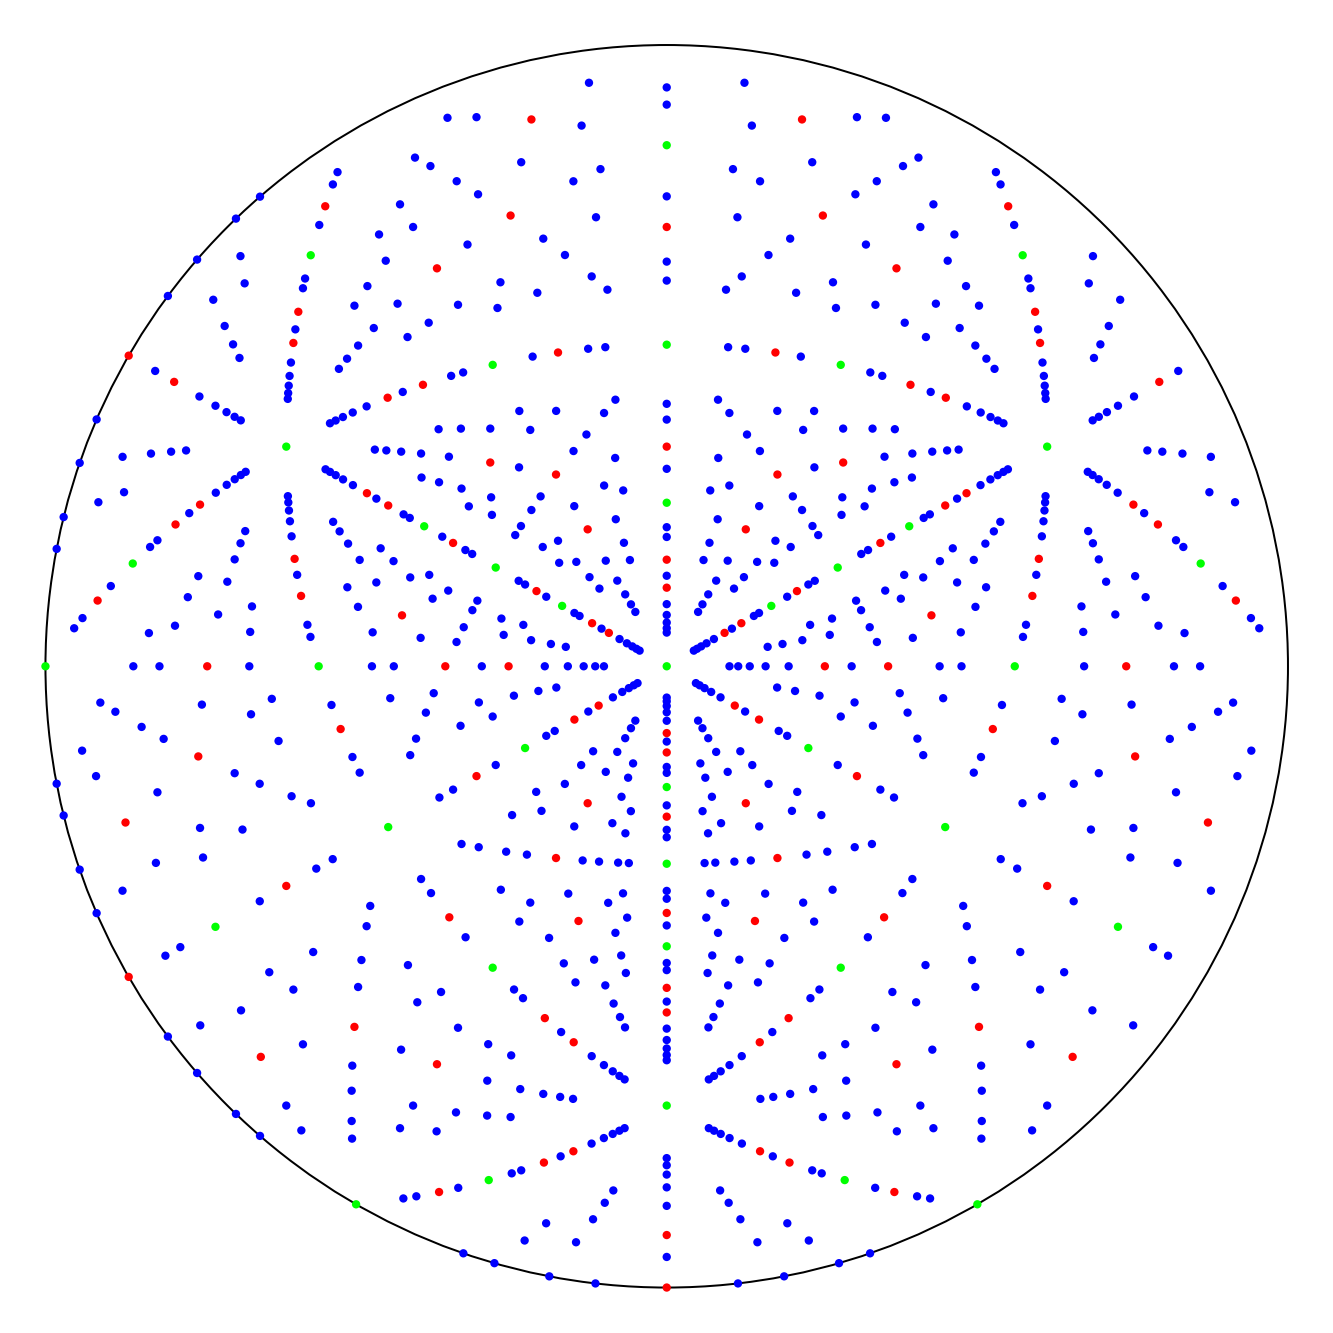

In [70]:
rgb = np.zeros_like(md7.uvw)
rgb[rgb_mask2] = 1

md7.scatter(c=rgb, s=10, grid=False, figure_kwargs=dict(figsize=(12, 12)))